In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from arch import arch_model
import statsmodels.api as sm
import scipy.stats as stats

# Definir data de início
start_date = '2018-01-01'

# Ativos de fundos imobiliários
ativos = [
    "HGRE11.SA",
    "BTLG11.SA",
    "HGRU11.SA",
    "VGIR11.SA"
]

# Baixar dados
data = yf.download(ativos, start=start_date)['Adj Close']

# Calcular retornos logarítmicos diários
returns = np.log(data / data.shift(1)).dropna()

[*********************100%%**********************]  4 of 4 completed


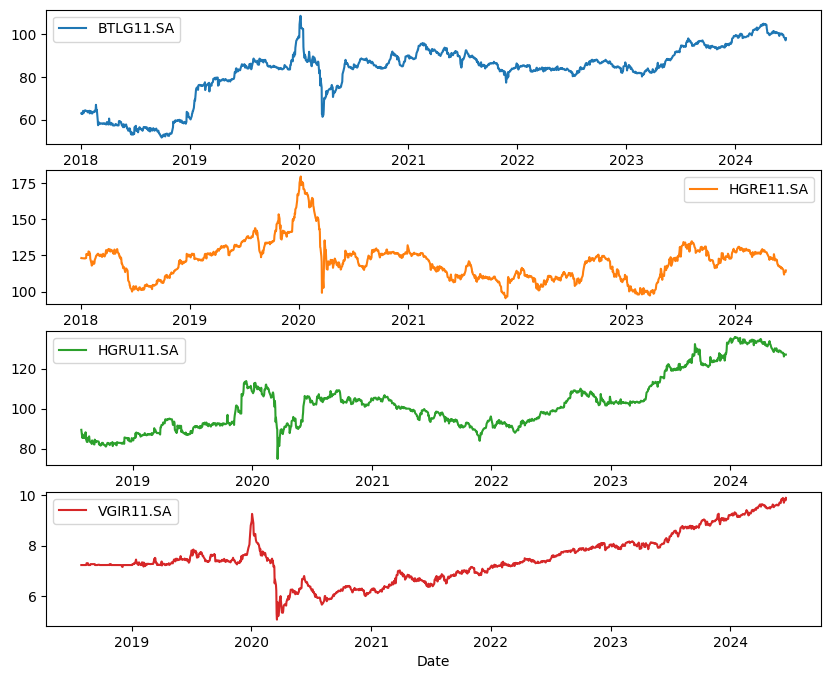

In [3]:
# Plotar preços ajustados
data.plot(subplots=True, layout=(len(ativos), 1), figsize=(10, 8), sharex=False)
plt.show()

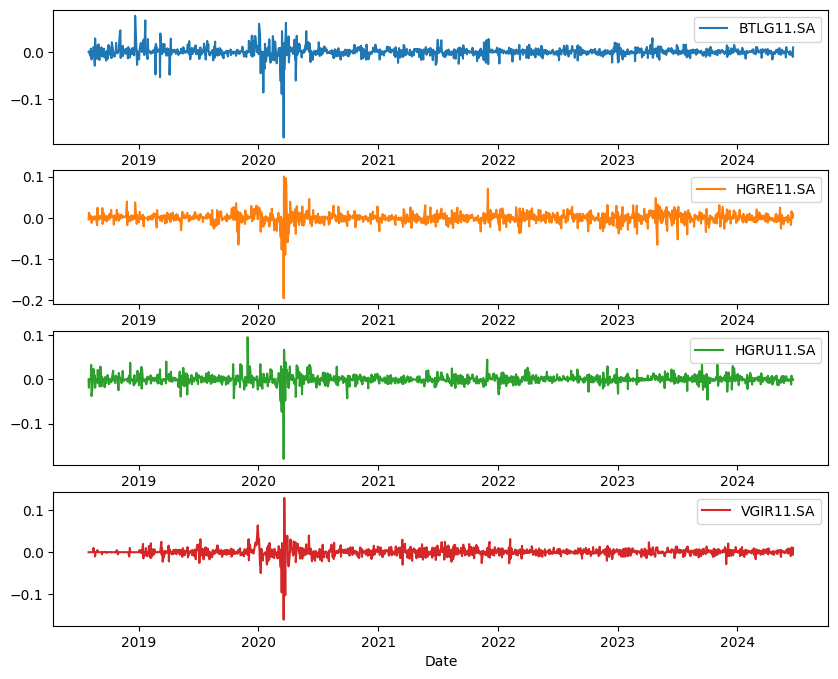

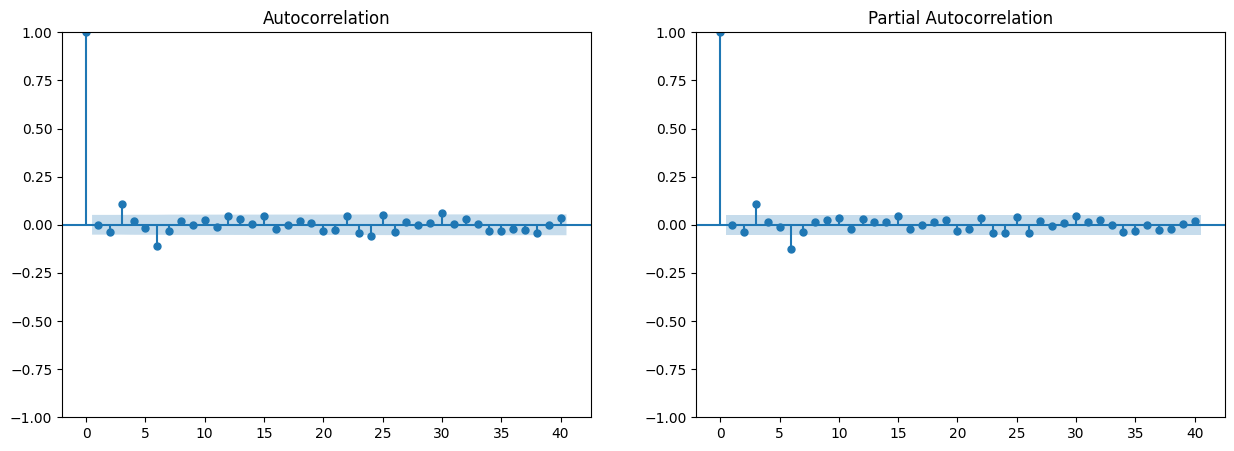

In [4]:
# Plotar retornos logarítmicos
returns.plot(subplots=True, layout=(len(ativos), 1), figsize=(10, 8), sharex=False)
plt.show()

# Data mínima comum a todas as séries
data_corte = returns.index.min()

# Filtrar dados para treino
da_train = returns.loc[data_corte:]
returns_squared = da_train**2

# Função para plotar ACF e PACF
def plot_acf_pacf(series, lags=40):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=axes[1])
    plt.show()

# Descritivas bacanas: ACF/PACF dos retornos
plot_acf_pacf(da_train['HGRE11.SA'])

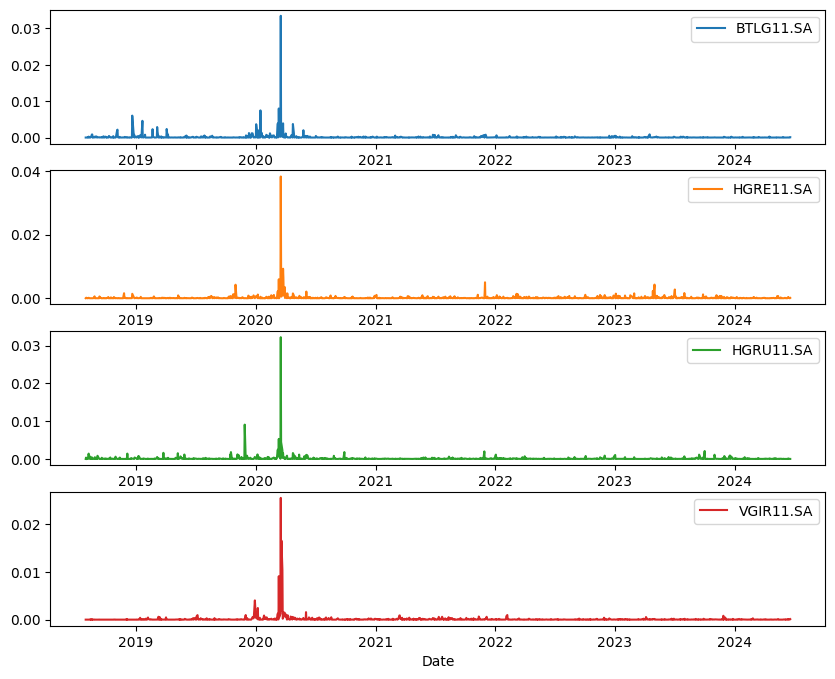

In [5]:
# Visualizar os retornos ao quadrado
returns_squared.plot(subplots=True, layout=(len(ativos), 1), figsize=(10, 8), sharex=False)
plt.show()

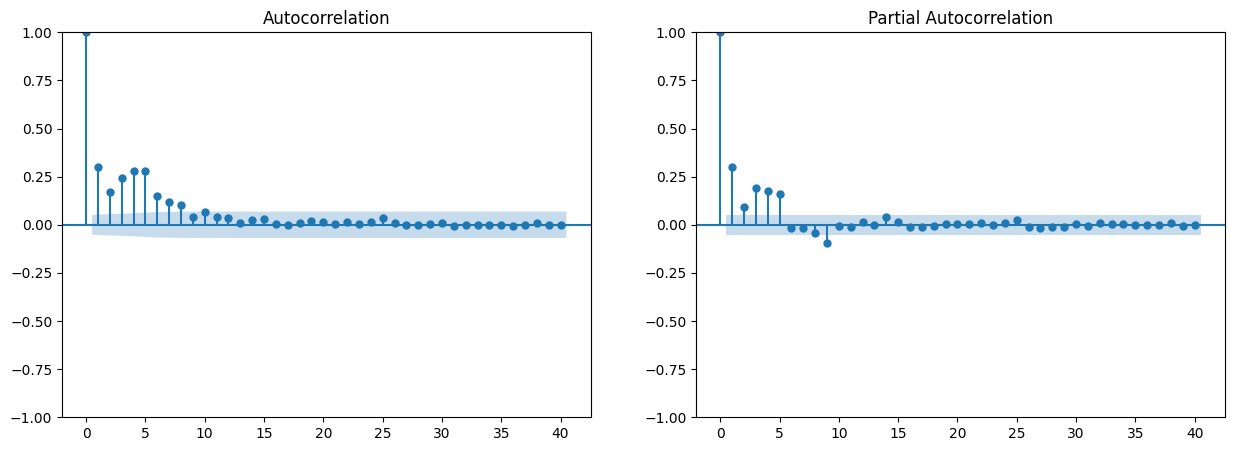

In [6]:
# ACF/PACF dos retornos ao quadrado
plot_acf_pacf(returns_squared['HGRE11.SA'])

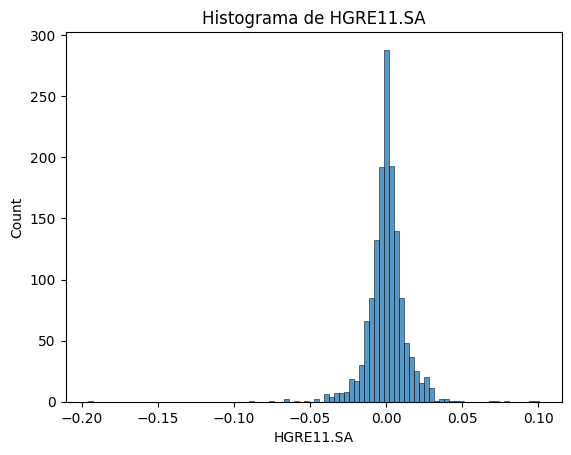

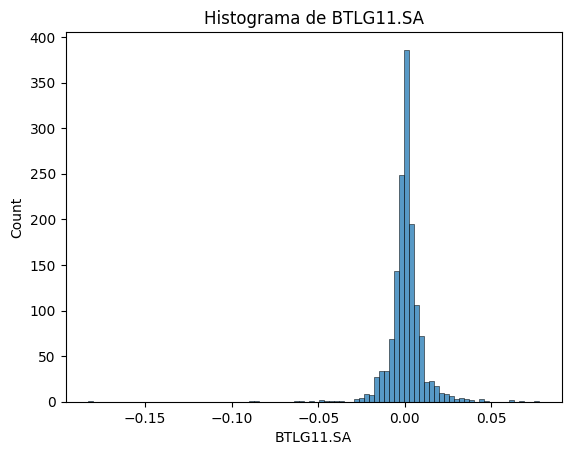

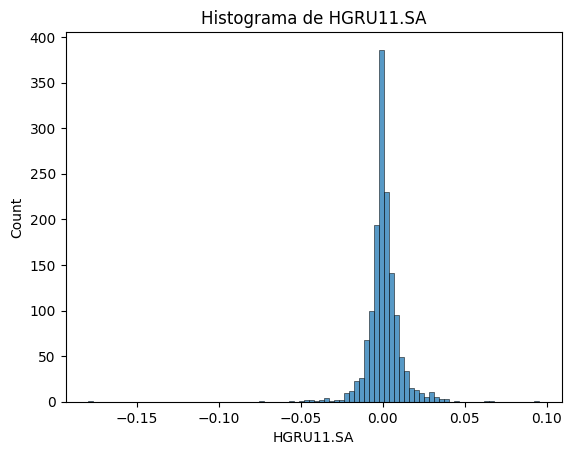

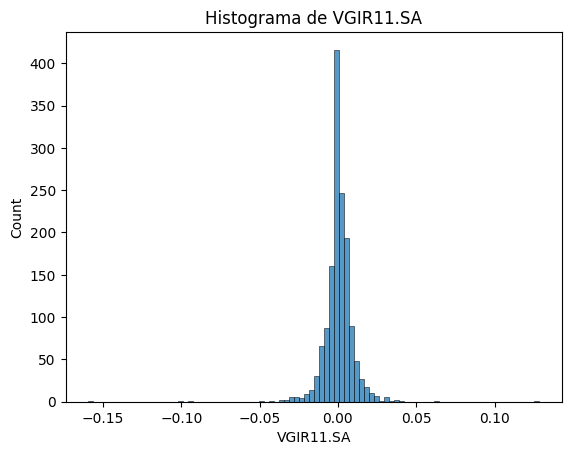

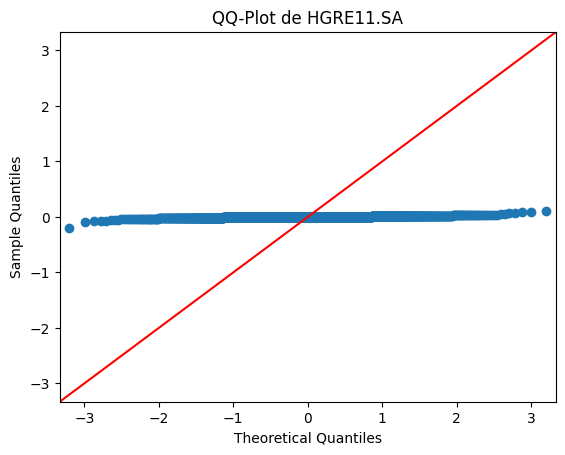

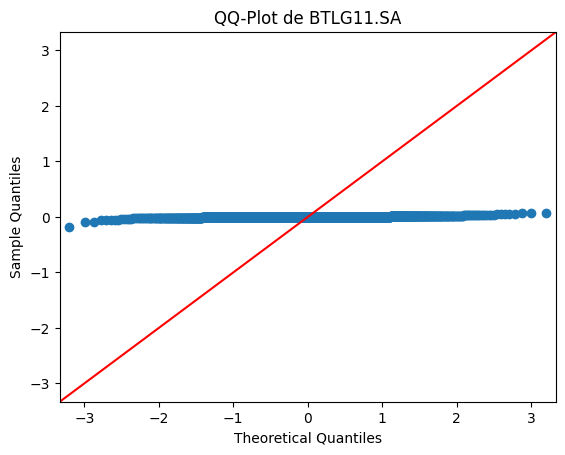

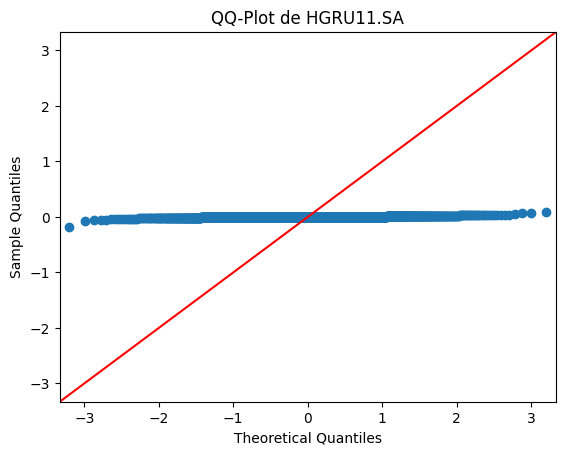

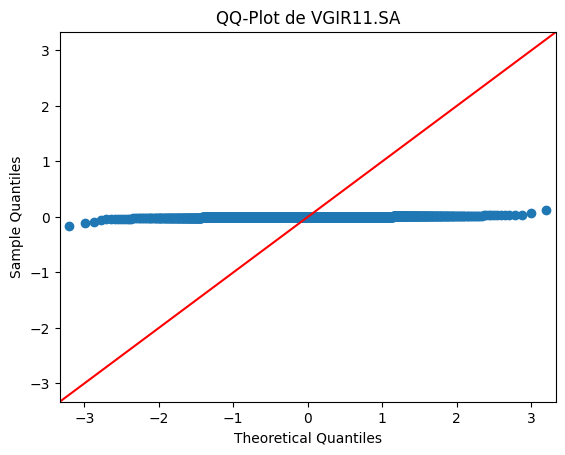

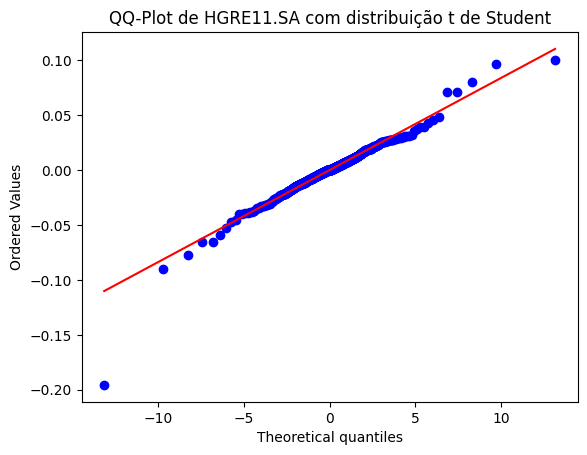

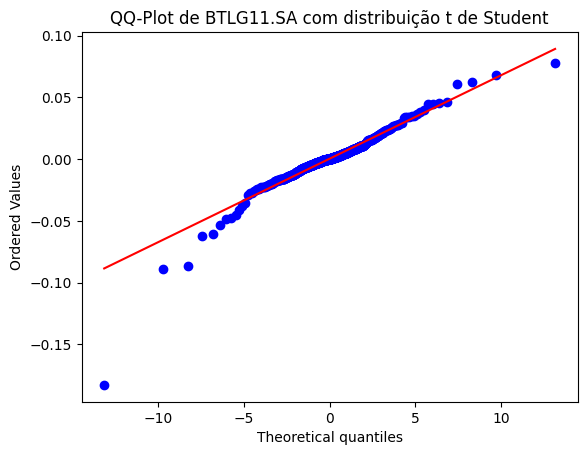

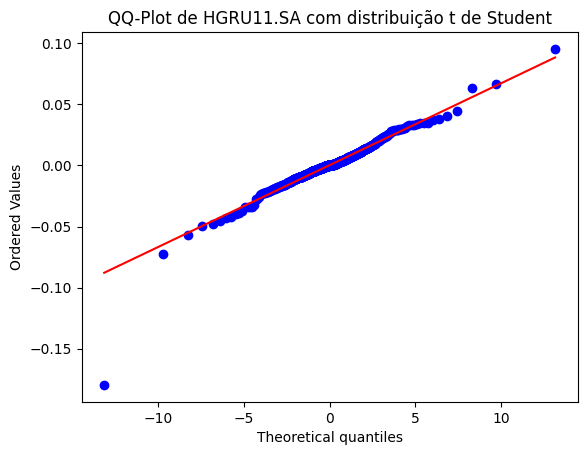

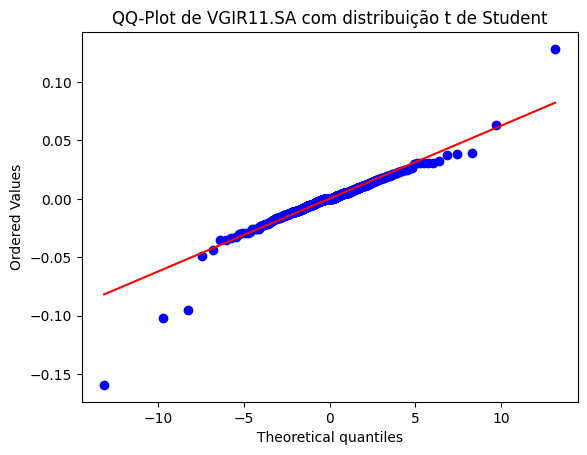

In [7]:
# Normalidade
# Histograma dos retornos
for ticker in ativos:
    sns.histplot(da_train[ticker], bins=90)
    plt.title(f'Histograma de {ticker}')
    plt.show()

# QQ-Plot para cada ticker
for ticker in ativos:
    sm.qqplot(da_train[ticker], line ='45')
    plt.title(f'QQ-Plot de {ticker}')
    plt.show()

# QQ-Plot com distribuição t de Student
for ticker in ativos:
    stats.probplot(da_train[ticker], dist="t", sparams=(3,), plot=plt)
    plt.title(f'QQ-Plot de {ticker} com distribuição t de Student')
    plt.show()

## Parte 2: ajustando os modelos


In [ ]:
import itertools

# Ajustar modelo GARCH individual
def garch_individual(parms, ret):
    garch_model = arch_model(ret, vol='Garch', p=parms['p'], q=parms['q'], dist=parms['dist'])
    try:
        fit = garch_model.fit(disp="off")
    except:
        fit = None
    return fit

# Testando para um ativo
params = {'p': 1, 'q': 1, 'dist': 't'}
ret = returns['HGRE11.SA']
resultado = garch_individual(params, ret * 100)

# Exibir critérios de informação
# if resultado:
#     print(resultado.summary())

# Função para ajustar uma grid de GARCHs e pegar as informações

## OMITIDO

# Rodando as funções
melhores_por_ativo = {}
for ativo in ativos:
    melhores_por_ativo[ativo] = melhor_garch(ativo, range(1, 3), range(3))


In [ ]:
# Função que ajusta o modelo e faz as previsões
def prever_volatilidade(parms, n_steps=5):
    ret = returns[parms['ticker']]
    garch_model = arch_model(ret * 100, vol='Garch', p=parms['p'], q=parms['q'], dist=parms['dist'])
    fit = garch_model.fit(disp="off")

    forecasts = fit.forecast(horizon=n_steps, reindex=False)
    sigma_forecasts = forecasts.variance.values[-1, :]
    mean_forecasts = forecasts.mean.values[-1, :]

    return pd.DataFrame({
        'ticker': parms['ticker'],
        'serie': mean_forecasts,
        'volatilidade': sigma_forecasts
    })

# Ajustando modelos finais e prevendo volatilidade futura
parametros_melhores = pd.DataFrame([
    {'ticker': ativo, **melhores_por_ativo[ativo].iloc[0]}
    for ativo in ativos
])

vol_futuro = []

## OMITIDO

## Otimização


In [ ]:
cov_mat = returns.cov() * 252

num_port = 5000
all_wts = np.zeros((num_port, len(returns.columns)))
port_returns = np.zeros((num_port))
port_risk = np.zeros((num_port))
sharpe_ratio = np.zeros((num_port))

for i in range(num_port):
  wts = np.random.uniform(size = len(returns.columns))
  wts = wts/np.sum(wts)

  # saving weights in the array
  all_wts[i,:] = wts

  # Portfolio Returns
  port_ret = np.sum(returns.mean() * wts)
  port_ret = (port_ret + 1) ** 252 - 1

  # Saving Portfolio returns
  port_returns[i] = port_ret

  # Portfolio Risk
  port_sd = np.sqrt(np.dot(wts.T, np.dot(cov_mat, wts)))
  port_risk[i] = port_sd

  # Portfolio Sharpe Ratio
  # Assuming 0% Risk Free Rate
  sr = port_ret / port_sd
  sharpe_ratio[i] = sr

names = returns.columns
min_var = all_wts[port_risk.argmin()]
max_sr = all_wts[sharpe_ratio.argmax()]

min_var, max_sr

In [ ]:
min_var = pd.Series(min_var, index=names)
min_var = min_var.sort_values()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Minimum Variance Portfolio weights")
min_var.plot(kind = 'bar')
plt.show()



max_sr = pd.Series(max_sr, index=names)
max_sr = max_sr.sort_values()
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Asset')
ax1.set_ylabel("Weights")
ax1.set_title("Tangency Portfolio weights")
max_sr.plot(kind = 'bar')
plt.show()

# fronteira
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])
ax1.set_xlabel('Risk')
ax1.set_ylabel("Returns")
ax1.set_title("Portfolio optimization and Efficient Frontier")
plt.scatter(port_risk, port_returns)
plt.show()

## CAPM

In [ ]:
# Pesos finais dos ativos no portfólio (exemplo)
pesos_finais = np.array(max_sr)

# Calculando os retornos do portfólio
portfolio_returns = (da_train * pesos_finais).sum(axis=1).to_frame('portfolio')

# Baixar dados do mercado (IBOVESPA)
market_data = yf.download('^BVSP', start=data_corte)['Adj Close']
# Calcular retornos logarítmicos diários do mercado
market_returns = np.log(market_data / market_data.shift(1)).dropna().to_frame('ibov')

# Combinar retornos do portfólio e do mercado
all_returns = market_returns.join(portfolio_returns, how='inner').dropna()

## OMITIDO